# CLTV Implementation in Python (Using Formula)

### Importing Required Library

In [1]:
import pandas as pd
import sqlite3
import matplotlib
from datetime import datetime
import numpy as np

### 1. Connecting to DB
### 2. Deriving Data

In [2]:
# Establish a connection to your SQLite database
conn = sqlite3.connect('temp.db')

In [3]:
query = '''
SELECT
    t.transaction_id AS transaction_id,
    t.transaction_date AS transaction_date,
    t.transaction_amount AS transaction_amount,
    p.property_type AS property_type,
    c.customer_id AS customer_id,
    c.country AS customer_country
FROM
    transactions t
JOIN
    sales_fact s ON t.transaction_id = s.transaction_id
JOIN
    property p ON s.property_id = p.property_id
JOIN
    customer c ON s.customer_id = c.customer_id;
'''

### Loading Dataset

In [4]:
# Read query results into a pandas DataFrame
df = pd.read_sql_query(query, conn)
df.head()

,transaction_id,transaction_date,transaction_amount,property_type,customer_id,customer_country
0,1,2009-11-25 17:43:00,1862497.50,Penthouse,1754,Russian Federation
1,2,2007-04-22 20:27:06,610835.40,Apartment,2671,Korea
2,3,2011-03-28 12:10:30,431379.05,Studio,212,South Georgia and the South Sandwich Islands
3,4,2000-01-02 12:54:19,634704.63,Loft,1101,Senegal
4,5,2006-02-13 11:42:47,1026119.60,Loft,813,Jordan


## Removing Duplicates
Sometimes you get a messy dataset. You may have to deal with duplicates, which will skew your analysis. In python, pandas offer function drop_duplicates(), which drops the repeated or duplicate records.

In [5]:
filtered_data=df[['customer_country','customer_id']].drop_duplicates()
filtered_data.head()

,customer_country,customer_id
0,Russian Federation,1754
1,Korea,2671
2,South Georgia and the South Sandwich Islands,212
3,Senegal,1101
4,Jordan,813


## Data Insights

<Axes: xlabel='customer_country'>

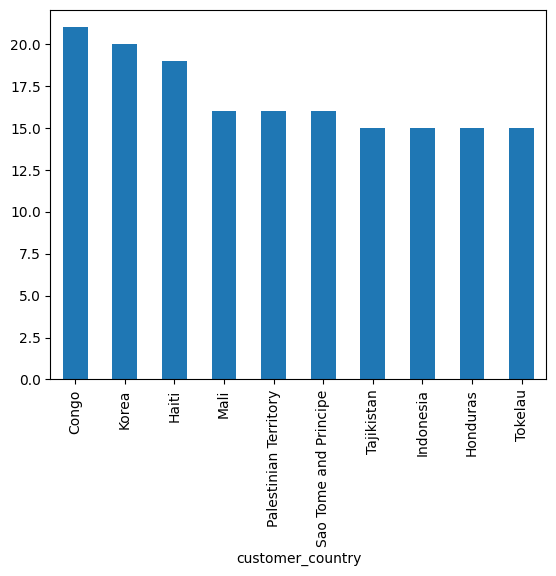

In [6]:
#Top ten country's customer
filtered_data.customer_country.value_counts()[:10].plot(kind='bar')


In the given dataset, you can observe most of the customers are from "Kongo". So, you can filter data for Kongo customer.

In [7]:
congo_data=df[df.customer_country =='Congo']
congo_data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 37 to 3993
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_id      48 non-null     int64  
 1   transaction_date    48 non-null     object 
 2   transaction_amount  48 non-null     float64
 3   property_type       48 non-null     object 
 4   customer_id         48 non-null     int64  
 5   customer_country    48 non-null     object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.6+ KB


The describe() function in pandas is convenient in getting various summary statistics. This function returns the count, mean, standard deviation, minimum and maximum values and the quantiles of the data.

In [8]:
congo_data.describe()

,transaction_id,transaction_amount,customer_id
count,48.000000,4.800000e+01,48.000000
mean,2198.770833,1.272306e+06,1672.875000
std,1271.424904,5.375591e+05,878.178691
min,38.000000,8.055067e+04,234.000000
25%,1066.000000,8.970621e+05,1160.000000
50%,2567.500000,1.391677e+06,1579.000000
75%,3221.750000,1.722601e+06,2500.750000
max,3994.000000,1.956532e+06,2948.000000


## Filter required Columns

Here, you can filter the necessary columns for calculating CLTV. You only need her four columns customer_id, transaction_date, transaction_id, and transaction_amount.

**customer_id** will uniquely define your customers.

**transaction_date** help you calculate numbers of days customer stayed with your product.

**transaction_amount** will help you to calculate the total purchased amount.

In [9]:
congo_data=congo_data[['customer_id','transaction_date','transaction_id','transaction_amount']]
congo_data.head()

,customer_id,transaction_date,transaction_id,transaction_amount
37,1211,2006-07-21 23:35:21,38,1928470.42
60,234,2019-03-06 08:01:58,61,842475.86
121,1953,2015-12-11 02:42:21,122,1129233.77
149,901,2008-09-10 09:38:13,150,1861021.15
189,1509,2000-08-21 03:22:11,190,568108.36


### Here, you are going to perform the following operations:

1. Calculate the number of days between the present date and the date of last purchase from each customer.

2. Calculate the number of purchases for each customer.

3. Calculate sum of purchase price for each customer.

In [10]:
congo_data['transaction_date'] = pd.to_datetime(congo_data['transaction_date'])

congo_data_group = congo_data.groupby('customer_id').agg({
    'transaction_date': lambda date: (date.max() - date.min()).days,
    'transaction_id': lambda num: len(num),
    'transaction_amount': lambda price: price.sum()
})

congo_data_group

,transaction_date,transaction_id,transaction_amount
customer_id,,,
234,7717,7,7774492.62
622,0,1,1541279.02
901,612,2,3450333.52
1160,5687,3,2886668.65
1200,5497,2,1555825.84
1211,1466,2,3562680.98
1387,0,1,1685304.82
1509,6759,3,2342310.90
1579,8127,5,7502713.73


### Rename the column

In [11]:
# Change the name of columns
congo_data_group.columns=['num_days', 'num_transactions', 'spent_money']
congo_data_group.head()


,num_days,num_transactions,spent_money
customer_id,,,
234,7717,7,7774492.62
622,0,1,1541279.02
901,612,2,3450333.52
1160,5687,3,2886668.65
1200,5497,2,1555825.84


## Calculate CLTV using following formula:

 CLTV = ((Average Order Value x Purchase Frequency)/Churn Rate) x Profit margin.

 Customer Value = Average Order Value * Purchase Frequency


### 1. Calculate Average Order Value

In [12]:
# Average Order Value
congo_data_group['avg_order_value']=congo_data_group['spent_money']/congo_data_group['num_transactions']
congo_data_group

,num_days,num_transactions,spent_money,avg_order_value
customer_id,,,,
234,7717,7,7774492.62,1.110642e+06
622,0,1,1541279.02,1.541279e+06
901,612,2,3450333.52,1.725167e+06
1160,5687,3,2886668.65,9.622229e+05
1200,5497,2,1555825.84,7.779129e+05
1211,1466,2,3562680.98,1.781340e+06
1387,0,1,1685304.82,1.685305e+06
1509,6759,3,2342310.90,7.807703e+05
1579,8127,5,7502713.73,1.500543e+06


### 2. Calculate Purchase Frequency

In [13]:
purchase_frequency=sum(congo_data_group['num_transactions'])/congo_data_group.shape[0]

### 3. Calculate Repeat Rate and Churn Rate

In [14]:
# Repeat Rate
repeat_rate=congo_data_group[congo_data_group.num_transactions > 1].shape[0]/congo_data_group.shape[0]


In [15]:
#Churn Rate
churn_rate=1-repeat_rate


In [16]:
purchase_frequency,repeat_rate,churn_rate


(2.2857142857142856, 0.6666666666666666, 0.33333333333333337)

### 4. Calculate Profit Margin

Profit margin is the commonly used profitability ratio. It represents how much percentage of total sales has earned as the gain. Let's assume our business has approx 5% profit on the total sale.

In [17]:
# Profit Margin
congo_data_group['profit_margin']=congo_data_group['spent_money']*0.05
congo_data_group.head()

,num_days,num_transactions,spent_money,avg_order_value,profit_margin
customer_id,,,,,
234,7717,7,7774492.62,1.110642e+06,388724.6310
622,0,1,1541279.02,1.541279e+06,77063.9510
901,612,2,3450333.52,1.725167e+06,172516.6760
1160,5687,3,2886668.65,9.622229e+05,144333.4325
1200,5497,2,1555825.84,7.779129e+05,77791.2920


### 5. Calcualte Customer Lifetime Value

In [18]:
# Customer Value
congo_data_group['CLV']=(congo_data_group['avg_order_value']*purchase_frequency)/churn_rate
congo_data_group.head()

,num_days,num_transactions,spent_money,avg_order_value,profit_margin,CLV
customer_id,,,,,,
234,7717,7,7774492.62,1.110642e+06,388724.6310,7.615830e+06
622,0,1,1541279.02,1.541279e+06,77063.9510,1.056877e+07
901,612,2,3450333.52,1.725167e+06,172516.6760,1.182971e+07
1160,5687,3,2886668.65,9.622229e+05,144333.4325,6.598100e+06
1200,5497,2,1555825.84,7.779129e+05,77791.2920,5.334260e+06


In [19]:
#Customer Lifetime Value
congo_data_group['cust_lifetime_value']=congo_data_group['CLV']*congo_data_group['profit_margin']
congo_data_group.head()

,num_days,num_transactions,spent_money,avg_order_value,profit_margin,CLV,cust_lifetime_value
customer_id,,,,,,,
234,7717,7,7774492.62,1.110642e+06,388724.6310,7.615830e+06,2.960461e+12
622,0,1,1541279.02,1.541279e+06,77063.9510,1.056877e+07,8.144712e+11
901,612,2,3450333.52,1.725167e+06,172516.6760,1.182971e+07,2.040823e+12
1160,5687,3,2886668.65,9.622229e+05,144333.4325,6.598100e+06,9.523264e+11
1200,5497,2,1555825.84,7.779129e+05,77791.2920,5.334260e+06,4.149590e+11


## Prediction Model for CLTV

Let's build the CLTV prediction model.

Here, you are going to predict CLTV using Linear Regression Model.

Let's first use the data loaded and filtered above.

Extract month and year from **transaction_date**

In [20]:
congo_data['month_yr'] = congo_data['transaction_date'].apply(lambda x: x.strftime('%b-%Y'))
congo_data.head()

,customer_id,transaction_date,transaction_id,transaction_amount,month_yr
37,1211,2006-07-21 23:35:21,38,1928470.42,Jul-2006
60,234,2019-03-06 08:01:58,61,842475.86,Mar-2019
121,1953,2015-12-11 02:42:21,122,1129233.77,Dec-2015
149,901,2008-09-10 09:38:13,150,1861021.15,Sep-2008
189,1509,2000-08-21 03:22:11,190,568108.36,Aug-2000


The pivot table takes the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summarization of the data.

In [21]:
sale=congo_data.pivot_table(index=['customer_id'],columns=['month_yr'],values='transaction_amount',aggfunc='sum',fill_value=0).reset_index()
sale.head()

month_yr,customer_id,Apr-2000,Apr-2006,Apr-2023,Aug-2000,Aug-2008,Aug-2013,Aug-2017,Aug-2023,Dec-2000,...,Nov-2015,Nov-2021,Oct-2000,Oct-2005,Oct-2023,Sep-2003,Sep-2007,Sep-2008,Sep-2012,Sep-2018
0,234,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,1138020.5,473668.92,0.0,0.0,0.00,0.0,0.00,0.00,0.00
1,622,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,1541279.02,0.00
2,901,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,1861021.15,0.00,0.00
3,1160,0.0,0.0,0.0,0.0,0.0,0.0,611881.77,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00
4,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.0,0.00,0.0,0.0,1009295.26,0.0,0.00,0.00,546530.58


Let's sum all the months sales.

In [22]:
sale['CLV']=sale.iloc[:,2:].sum(axis=1)
sale.head()

month_yr,customer_id,Apr-2000,Apr-2006,Apr-2023,Aug-2000,Aug-2008,Aug-2013,Aug-2017,Aug-2023,Dec-2000,...,Nov-2021,Oct-2000,Oct-2005,Oct-2023,Sep-2003,Sep-2007,Sep-2008,Sep-2012,Sep-2018,CLV
0,234,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,1138020.5,473668.92,0.0,0.0,0.00,0.0,0.00,0.00,0.00,7774492.62
1,622,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,1541279.02,0.00,1541279.02
2,901,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,1861021.15,0.00,0.00,3450333.52
3,1160,0.0,0.0,0.0,0.0,0.0,0.0,611881.77,0.0,0.0,...,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.00,2886668.65
4,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,...,0.0,0.00,0.0,0.0,1009295.26,0.0,0.00,0.00,546530.58,1555825.84


### Selecting Feature

Here, you need to divide the given columns into two types of variables dependent(or target variable) and independent variable(or feature variables). Select latest 6 month as independent variable.

In [23]:
# Convert date strings to datetime objects
date_objects = [datetime.strptime(date, '%b-%Y') for date in congo_data.month_yr]

# Sort datetime objects in descending order
sorted_dates = sorted(date_objects)

# Select the 6 most recent dates
six_most_recent_dates = sorted_dates[-6:]

# Convert datetime objects back to date strings
six_most_recent_dates = [date.strftime('%b-%Y') for date in six_most_recent_dates]

six_most_recent_dates

['Jul-2021', 'Nov-2021', 'Apr-2023', 'May-2023', 'Aug-2023', 'Oct-2023']

In [24]:
X=sale[six_most_recent_dates]
y=sale[['CLV']]


### Splitting Data

To understand model performance, dividing the dataset into a training set and a test set is a good strategy.

Let's split dataset by using function train_test_split(). You need to pass 3 parameters features, target, and test_set size. Additionally, you can use random_state as a seed value to maintain reproducibility, which means whenever you split the data will not affect the results. Also, if random_state is None, then random number generator uses np.random for selecting records randomly. It means If you don't set a seed, it is different each time.

In [25]:
#split training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)


### Model Development

First, import the Linear Regression module and create a Linear Regression object. Then, fit your model on the train set using fit() function and perform prediction on the test set using predict() function.

In [26]:
# import model
from sklearn.linear_model import LinearRegression

# instantiate
linreg = LinearRegression()

# fit the model to the training data (learn the coefficients)
linreg.fit(X_train, y_train)

# make predictions on the testing set
y_pred = linreg.predict(X_test)


In [27]:
# print the intercept and coefficients
print(linreg.intercept_)
print(linreg.coef_)


[2422918.5025]
[[0.         4.70252875 0.43171048 0.         0.66875545 1.50523048]]


### How Well Does the Model Fit the data?

In order to evaluate the overall fit of the linear model, we use the R-squared value. R-squared is the proportion of variance explained by the model. Value of R-squared lies between 0 and 1. Higher value or R-squared is considered better because it indicates the larger variance explained by the model.

In [28]:
from sklearn import metrics

# compute the R Square for model
print("R-Square:",metrics.r2_score(y_test, y_pred))

R-Square: -0.015256877240437117


### Model Evaluation

For regression problems following evaluation metrics used (Ritchie Ng):

* Mean Absolute Error (MAE) is the mean of the absolute value of the errors.

* Mean Squared Error (MSE) is the mean of the squared errors.

* Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors.

RMSE is more popular than MSE and MAE because RMSE is interpretable with y because of the same units.

In [29]:
# calculate MAE using scikit-learn
print("MAE:",metrics.mean_absolute_error(y_test,y_pred))

#calculate mean squared error
print("MSE",metrics.mean_squared_error(y_test, y_pred))
# compute the RMSE of our predictions
print("RMSE:",np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


MAE: 1823303.4408333336
MSE 5820739094035.681
RMSE: 2412620.7936672685
